# 用随机森林回归填补缺失值

# 1.导入需要的库

In [34]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer       #可以用来轻松的将均值，中值或其他常用的数值填充到数据里
from sklearn.model_selection import cross_val_score

# 2.以波士顿数据为例，导入完整的数据集并探索

In [4]:
dataset = load_boston()

In [8]:
#总共506*13=6578个数据
dataset.data.shape

(506, 13)

In [9]:
#将数据放入x_full,y_full，避免影响原数据
x_full, y_full = dataset.data, dataset.target
#例子个数
n_samples = x_full.shape[0]       
#特征个数
n_features = x_full.shape[1]

## 3.为完整数据放入缺失值

In [10]:
# 1.确定缺失率，求出缺失数据个数
missing_rate = 0.5
n_missing_samples = int(np.floor(n_samples*n_features*missing_rate))

# 2.生成要替换成缺失数据的坐标
rng = np.random.RandomState(0)
missing_samples = rng.randint(0, n_samples, n_missing_samples)
missing_features = rng.randint(0, n_features, n_missing_samples)

# 3.从x_full, y_full中赋值数据，避免影响x_full,y_full
x_missing = x_full.copy()
y_missing = y_full.copy()

# 4.替换数据np.nan
x_missing[missing_samples, missing_features] = np.nan

# 5.将缺失矩阵替换成DataFrame
x_missing = pd.DataFrame(x_missing)

## 4.使用0和均值填补缺失值

In [11]:
# 使用0进行填补
imp_0 = SimpleImputer(missing_values = np.nan, strategy = "constant", fill_value = 0)
x_missing_0 = imp_0.fit_transform(x_missing)    #将缺失数据替换为0并且输出来

# 使用均值
imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')
x_missing_mean = imp_mean.fit_transform(x_missing)

## 5.使用随机森立填补缺失值

In [29]:
# 获取每列含缺失值的个数，并进行排序
x_missing_reg = x_missing.copy()
sortindex = np.argsort(x_missing_reg.isnull().sum(axis=0)).values

In [31]:
# 从缺失值最少的列开始，对每列使用随机森林填补缺失值
for i in sortindex:
    # 1.构建我们的新特征矩阵和新标签（缺失值最少的列）
    df = x_missing_reg.copy()
    fillc = df.iloc[:,i]
    df = pd.concat([df.iloc[:,df.columns != i],pd.DataFrame(y_full)],axis=1)
    
    # 2.在新矩阵中，对含有缺失值的列用0填补
    df_0 = SimpleImputer(missing_values = np.nan
                        ,strategy = "constant"
                        ,fill_value = 0).fit_transform(df)
    
    # 3.求出训练集和测试集
    Ytrain = fillc[fillc.notnull()]
    Ytest = fillc[fillc.isnull()]
    Xtrain = df_0[Ytrain.index,:]
    Xtest = df_0[Ytest.index,:]
    
    # 4.用随机森林回归来填补标签列缺失值
    rfc = RandomForestRegressor(n_estimators = 100)
    rfc = rfc.fit(Xtrain, Ytrain)
    Ypredict = rfc.predict(Xtest)
    
    # 5.将填补好的特征值替换原来特征矩阵的缺失值
    x_missing_reg.loc[x_missing_reg.iloc[:,i].isnull(),i] = Ypredict
    

## 6.对填补好的数据进行建模测试误差

In [36]:
X = [x_full, x_missing_mean, x_missing_0, x_missing_reg]

mse = []

for x in X:
    estimator = RandomForestRegressor(random_state = 0, n_estimators = 100)
    scores = cross_val_score(estimator, x, y_full,scoring = 'neg_mean_squared_error', cv = 5).mean()
    mse.append(-1*scores)

## 7.用所得结果画出条形图

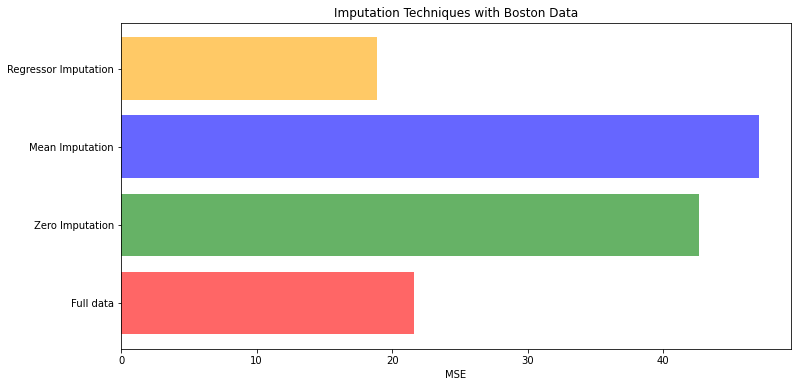

In [40]:
plt.figure(figsize = (12,6))

colors = ['r', 'g', 'b', 'orange']

ax = plt.subplot(111)
for i in np.arange(len(mse)):
    ax.barh(i, mse[i], color = colors[i], alpha = 0.6, align = 'center')

ax.set_title('Imputation Techniques with Boston Data')

ax.set_xlabel('MSE')

ax.set_yticks(np.arange(len(mse)))

x_labels = ['Full data',
            'Zero Imputation',
            'Mean Imputation',
            'Regressor Imputation']

ax.set_yticklabels(x_labels)

plt.show()